Please upload your 'NLP_Prompt.xlsx - Sheet1.csv' file:


Saving NLP_Prompt.csv to NLP_Prompt (1).csv

Successfully uploaded: NLP_Prompt (1).csv

--- Columns Found by Pandas ---
['prompt_text', 'is_vague', 'no_action_verb', 'no_format', 'is_good']

--- Dataset Head ---
                                         prompt_text  is_vague  \
0                                Tell me about dogs.         1   
1                                 Quantum computing.         1   
2      Write a 3-para summary of the causes of WWII.         0   
3                                What's the weather?         1   
4  Generate a Python script to parse CSV files an...         0   

   no_action_verb  no_format  is_good  
0               0          1        0  
1               1          1        0  
2               0          0        1  
3               0          1        0  
4               0          0        1  

Generating Plot 1: Label Distribution...


/tmp/ipython-input-393804763.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


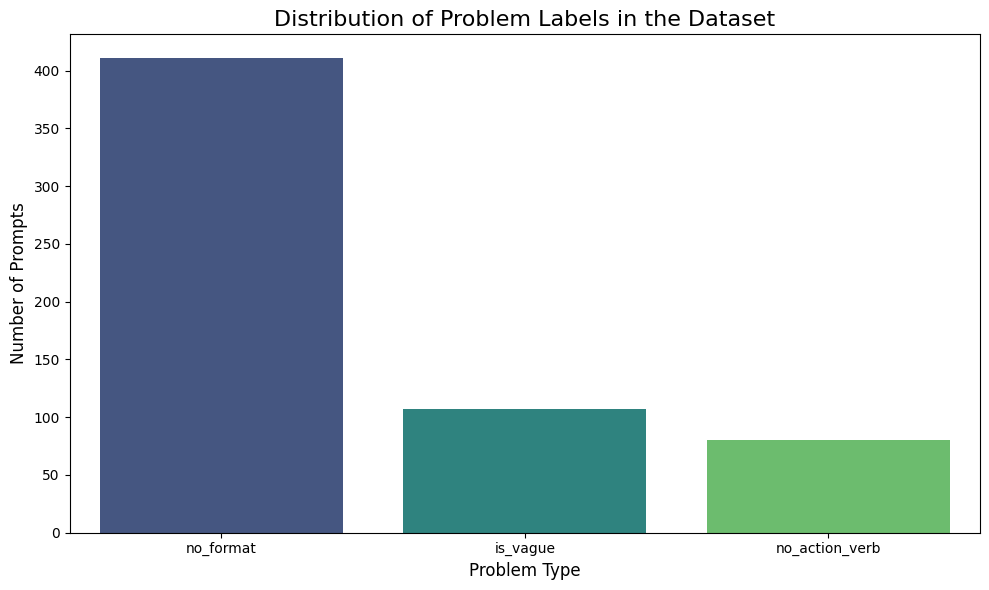


--- Data Split ---
Total examples: 715
Training examples: 572
Testing examples: 143

Training evaluation model on 80% of data...
Training complete.

Evaluating model on 20% 'unseen' test data...

--- MODEL PERFORMANCE REPORT ---
                precision    recall  f1-score   support

      is_vague       0.90      0.86      0.88        21
no_action_verb       0.94      0.94      0.94        16
     no_format       0.86      0.92      0.89        76

     micro avg       0.88      0.91      0.90       113
     macro avg       0.90      0.91      0.90       113
  weighted avg       0.88      0.91      0.90       113
   samples avg       0.48      0.48      0.48       113


Generating Plot 2: Confusion Matrices for Test Set...


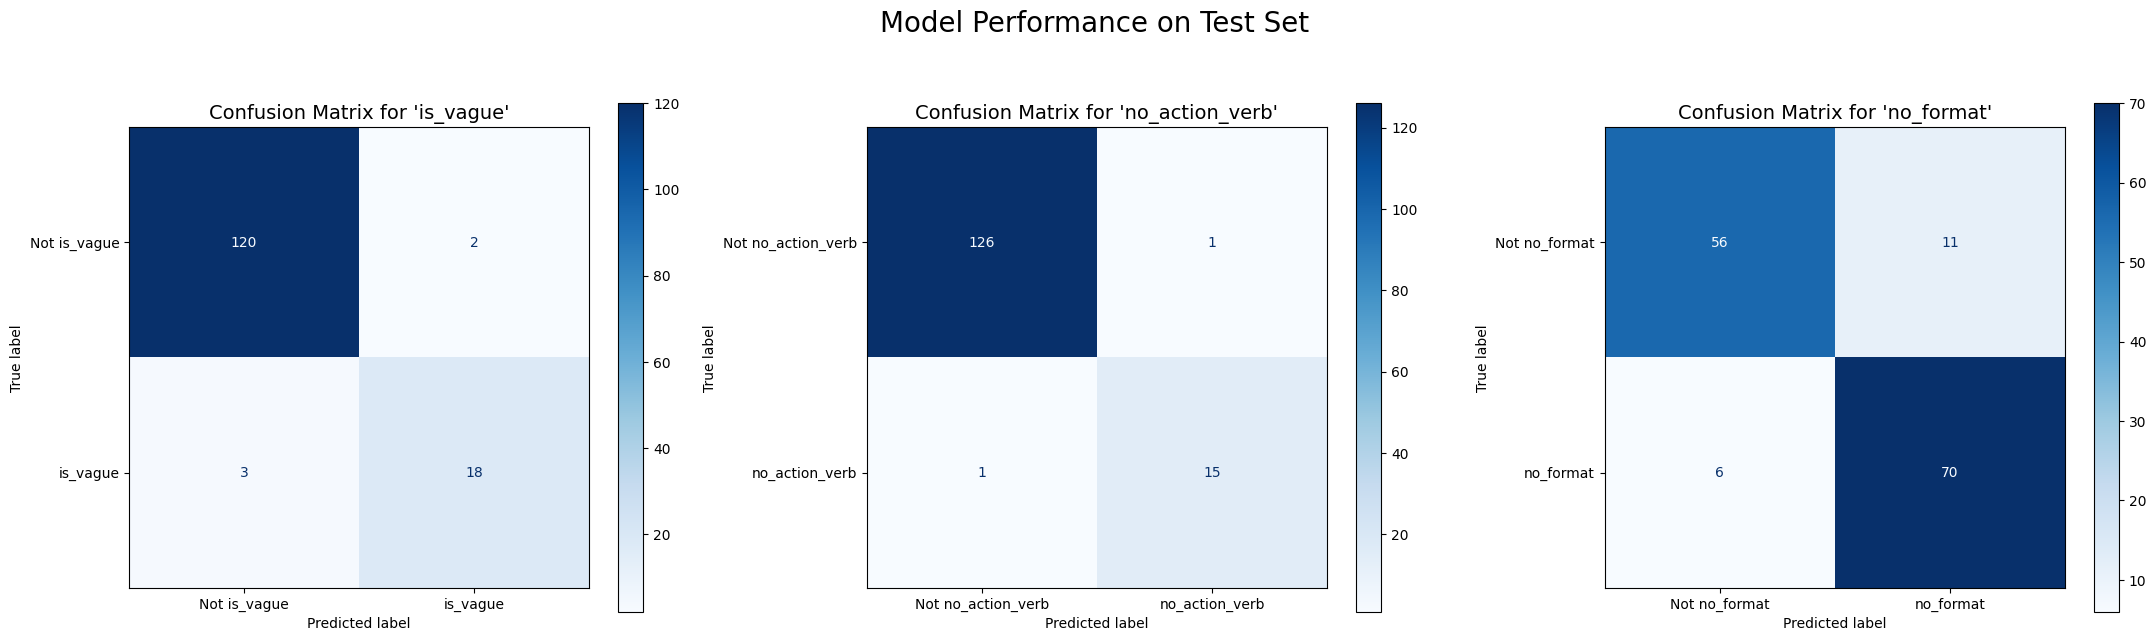


--- Training Final Production Model ---
Training a new model on 100% of your data...
Final model training complete!

Model saved successfully as: prompt_classifier.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay

print("Please upload your 'NLP_Prompt.csv' file:")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(f"\nSuccessfully uploaded: {file_name}")

try:
    df = pd.read_csv(
        file_name,
        encoding='latin1',
        engine='python',
        on_bad_lines='skip'
    )

    print("\n--- Columns Found by Pandas ---")
    print(list(df.columns))

    print("\n--- Dataset Head ---")
    print(df.head())

    label_cols = ['is_vague', 'no_action_verb', 'no_format']

    missing_cols = [col for col in label_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following required columns are missing: {missing_cols}. Please check your CSV header.")

    print("\nGenerating Plot 1: Label Distribution...")
    plt.figure(figsize=(10, 6))
    label_counts = df[label_cols].sum().sort_values(ascending=False)
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
    plt.title('Distribution of Problem Labels in the Dataset', fontsize=16)
    plt.ylabel('Number of Prompts', fontsize=12)
    plt.xlabel('Problem Type', fontsize=12)
    plt.tight_layout()
    plt.show()

    X = df['prompt_text'].fillna('').astype(str)
    y = df[label_cols]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("\n--- Data Split ---")
    print(f"Total examples: {len(X)}")
    print(f"Training examples: {len(X_train)}")
    print(f"Testing examples: {len(X_test)}")


    eval_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultiOutputClassifier(LogisticRegression(solver='liblinear', class_weight='balanced')))
    ])

    print("\nTraining evaluation model on 80% of data...")
    eval_pipeline.fit(X_train, y_train)
    print("Training complete.")

    print("\nEvaluating model on 20% 'unseen' test data...")
    y_pred = eval_pipeline.predict(X_test)

    print("\n--- MODEL PERFORMANCE REPORT ---")
    report = classification_report(y_test, y_pred, target_names=label_cols, zero_division=0)
    print(report)

    print("\nGenerating Plot 2: Confusion Matrices for Test Set...")
    matrices = multilabel_confusion_matrix(y_test, y_pred)

    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    for i, (label, matrix) in enumerate(zip(label_cols, matrices)):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[f'Not {label}', label])
        disp.plot(ax=axes[i], cmap='Blues')
        axes[i].set_title(f"Confusion Matrix for '{label}'", fontsize=14)
    plt.suptitle('Model Performance on Test Set', fontsize=20, y=1.05)
    plt.tight_layout()
    plt.show()


    print("\n--- Training Final Production Model ---")
    print("Training a new model on 100% of your data...")


    final_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultiOutputClassifier(LogisticRegression(solver='liblinear', class_weight='balanced')))
    ])


    final_pipeline.fit(X, y)
    print("Final model training complete!")


    model_filename = 'prompt_classifier.pkl'
    joblib.dump(final_pipeline, model_filename)
    print(f"\nModel saved successfully as: {model_filename}")

    print(f"Downloading '{model_filename}' to your computer...")
    files.download(model_filename)

except Exception as e:
    print(f"\nAn error occurred: {e}")
    print("Please make sure you uploaded the correct CSV file and that the column names match.")